# LSTM Model For Univariate Blood Glucose Forecasting

We will first try to forecast the blood glucose level of an individual by only regarding his past BG levels.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import mean_squared_error as mse
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
import os
# to avoid a kernel crash during the fit of the model
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# we import the datasets of the patient number 559
train_df = pd.read_csv('data/csv/2018/train/559-ws-training-glucose_level.csv')
test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-glucose_level.csv')

In [3]:
# we create datetime index
train_df.index = pd.to_datetime(train_df['ts'], format = "%d-%m-%Y %H:%M:%S")
test_df.index = pd.to_datetime(test_df['ts'], format = "%d-%m-%Y %H:%M:%S")

In [4]:
# now that we have a datetime index, we can remove the timestamp 'ts' columns
train_df = train_df.drop('ts', axis=1)
test_df = test_df.drop('ts', axis=1)

In [5]:
print(train_df.shape)
print(test_df.shape)
train_df

(10796, 1)
(2514, 1)


,value
ts,
2021-12-07 01:17:00,101
2021-12-07 01:22:00,98
2021-12-07 01:27:00,104
2021-12-07 01:32:00,112
2021-12-07 01:37:00,120
...,...
2022-01-17 23:36:00,161
2022-01-17 23:41:00,164
2022-01-17 23:46:00,168


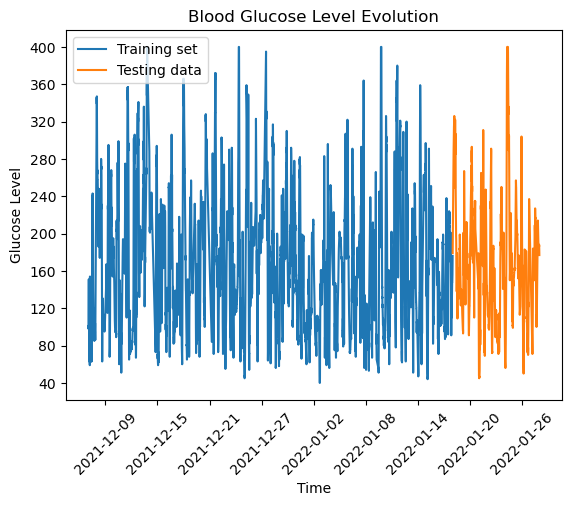

In [7]:
# we can plot the our whole data containing the training set and the testing set
fig, ax = plt.subplots()
ax.plot(train_df.index, train_df['value'], label='Training set')
ax.plot(test_df.index, test_df['value'], label='Testing data')

ax.set_xlabel('Time')
ax.set_ylabel('Glucose Level')
ax.set_title('Blood Glucose Level Evolution')

ax.xaxis.set_tick_params(rotation=45) 
ax.xaxis.set_major_locator(plt.MaxNLocator(10)) 
ax.yaxis.set_major_locator(plt.MaxNLocator(10)) 

ax.legend()
plt.show()

In [8]:
# managing missing values
print(train_df.isna().sum())
print(test_df.isna().sum())

value    0
dtype: int64
value    0
dtype: int64


In [40]:
# preparing independant and dependant features
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def prepare_data_1(timeseries_data, window_size):
    df_as_np = timeseries_data.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np)-window_size):
        row  = [a[0] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        #print(row)
        #print(label)
        y.append(label)
    return np.array(X), np.array(y)


In [41]:
# we choose a number of time steps
window_size = 15

# split into samples
X, y = prepare_data_1(train_df, window_size)
X_test, y_test = prepare_data_1(test_df, window_size)

In [42]:
print(X), print(y)

[[101  98 104 ... 150 124 130]
 [ 98 104 112 ... 124 130 127]
 [104 112 120 ... 130 127 121]
 ...
 [145 147 148 ... 158 161 164]
 [147 148 148 ... 161 164 168]
 [148 148 148 ... 164 168 172]]
[127 121 115 ... 168 172 176]


(None, None)

In [43]:
print(X_test), print(y_test)

[[179 183 187 ... 225 233 237]
 [183 187 191 ... 233 237 241]
 [187 191 195 ... 237 241 246]
 ...
 [182 184 187 ... 186 185 183]
 [184 187 188 ... 185 183 182]
 [187 188 188 ... 183 182 180]]
[241 246 248 ... 182 180 177]


(None, None)

In [44]:
X.shape, y.shape

((10781, 15), (10781,))

In [45]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

X.shape, X_test.shape

((10781, 15, 1), (2499, 15, 1))

In [46]:
X_train, y_train = X[:8500], y[:8500]
X_val, y_val = X[8500:], y[8500:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((8500, 15, 1), (8500,), (2281, 15, 1), (2281,), (2499, 15, 1), (2499,))

### Building LSTM model

In [47]:
# define model
model1 = Sequential()
model1.add(InputLayer((window_size,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'ReLU'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [48]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [50]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
266/266 [==============================] - 4s 14ms/step - loss: 15148.3105 - root_mean_squared_error: 123.0785 - val_loss: 11002.0498 - val_root_mean_squared_error: 104.8907
Epoch 2/10
266/266 [==============================] - 5s 18ms/step - loss: 6687.6670 - root_mean_squared_error: 81.7782 - val_loss: 4913.8281 - val_root_mean_squared_error: 70.0987
Epoch 3/10
266/266 [==============================] - 7s 26ms/step - loss: 2759.0283 - root_mean_squared_error: 52.5265 - val_loss: 2377.6025 - val_root_mean_squared_error: 48.7607
Epoch 4/10
266/266 [==============================] - 7s 25ms/step - loss: 1247.9822 - root_mean_squared_error: 35.3268 - val_loss: 1274.3710 - val_root_mean_squared_error: 35.6983
Epoch 5/10
266/266 [==============================] - 4s 15ms/step - loss: 645.0067 - root_mean_squared_error: 25.3970 - val_loss: 751.0293 - val_root_mean_squared_error: 27.4049
Epoch 6/10
266/266 [==============================] - 4s 15ms/step - loss: 375.2979 - root_me

In [51]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
train_results

266/266 [==============================] - 1s 4ms/step


,Train Predictions,Actuals
0,139.90,127
1,124.89,121
2,118.65,115
3,111.10,111
4,110.09,109
...,...,...
8495,81.18,87
8496,92.63,92
8497,96.28,88
8498,86.42,84


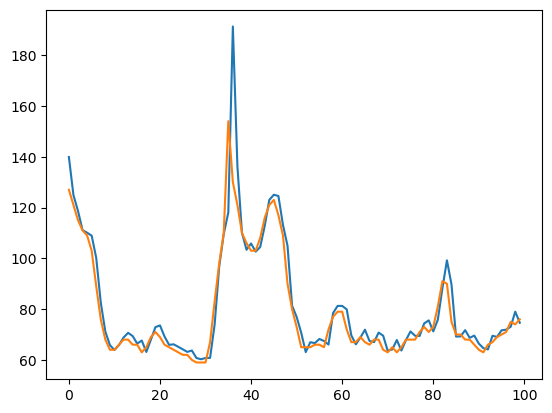

In [52]:
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100]) # affichage mauvais

In [53]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
val_results

72/72 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,77.44,73
1,71.46,70
2,70.10,68
3,68.57,67
4,68.15,66
...,...,...
2276,160.47,161
2277,164.21,164
2278,167.45,168
2279,172.04,172


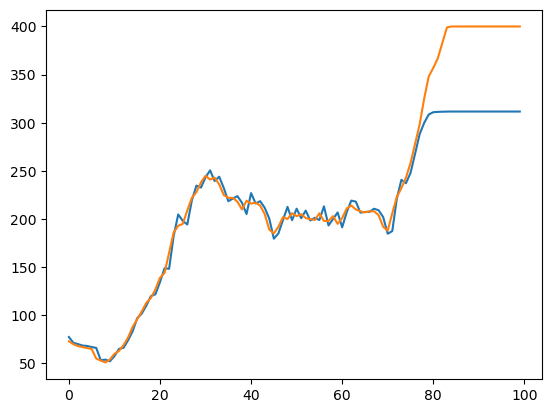

In [54]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [55]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
test_results

79/79 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,239.72,241
1,243.49,246
2,250.19,248
3,250.77,250
4,251.71,252
...,...,...
2494,186.47,185
2495,185.48,183
2496,182.94,182
2497,182.68,180


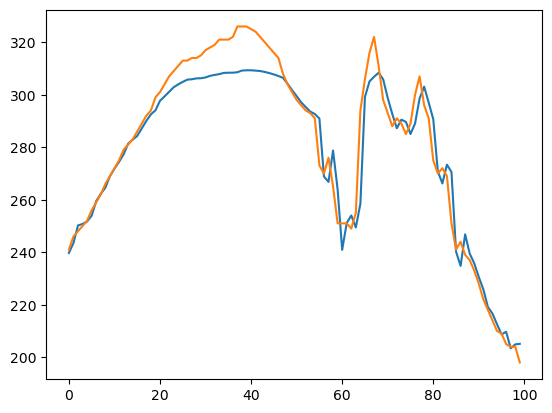

In [56]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

# LSTM Model For Bi-variate Blood Glucose Forecasting

We will now try to forecast the blood glucose level of an individual regarding both his past BG levels and his heart rate

### Data Preprocessing

In [100]:
# Blood Glucose data
train_df_BG = pd.read_csv('data/csv/2018/train/559-ws-training-glucose_level.csv')
test_df_BG = pd.read_csv('data/csv/2018/test/559-ws-testing-glucose_level.csv')

train_df_BG.index = pd.to_datetime(train_df_BG['ts'], format = "%d-%m-%Y %H:%M:%S")
test_df_BG.index = pd.to_datetime(test_df_BG['ts'], format = "%d-%m-%Y %H:%M:%S")

train_df_BG = train_df_BG.drop('ts', axis=1)
test_df_BG = test_df_BG.drop('ts', axis=1)

# Basis Heart Rate data
train_df_BHR = pd.read_csv('data/csv/2018/train/559-ws-training-basis_heart_rate.csv')
test_df_BHR = pd.read_csv('data/csv/2018/test/559-ws-testing-basis_heart_rate.csv')

train_df_BHR.index = pd.to_datetime(train_df_BHR['ts'], format = "%d-%m-%Y %H:%M:%S")
test_df_BHR.index = pd.to_datetime(test_df_BHR['ts'], format = "%d-%m-%Y %H:%M:%S")

train_df_BHR = train_df_BHR.drop('ts', axis=1)
test_df_BHR = test_df_BHR.drop('ts', axis=1)

In [101]:
print("Blood Glucose Level (Train set)")
print(train_df_BG.describe())

print("Basis Heart Rate (Train set)")
print(train_df_BHR.describe())

Blood Glucose Level (Train set)
         value
count 10796.00
mean    166.69
std      70.58
min      40.00
25%     108.00
50%     157.00
75%     212.00
max     400.00
Basis Heart Rate (Train set)
         value
count 11979.00
mean     73.59
std      15.80
min      46.00
25%      62.00
50%      69.00
75%      82.00
max     189.00


In [102]:
print("Blood Glucose Level (Test set)")
print(test_df_BG.describe())

print("Basis Heart Rate (Test set)")
print(test_df_BHR.describe())

Blood Glucose Level (Test set)
        value
count 2514.00
mean   169.53
std     66.96
min     45.00
25%    121.00
50%    162.00
75%    205.00
max    400.00
Basis Heart Rate (Test set)
        value
count 2633.00
mean    74.95
std     17.55
min     51.00
25%     61.00
50%     69.00
75%     86.00
max    174.00


In [103]:
print("\nTemporal range of BG training & testing sets: ") 
print("training: ", train_df_BG.index.max() - train_df_BG.index.min())
print("testing: ", test_df_BG.index.max() - test_df_BG.index.min())

print("\nTemporal range of BHR training & testing sets: ") 
print("training: ", train_df_BHR.index.max() - train_df_BHR.index.min())
print("testing: ", test_df_BHR.index.max() - test_df_BHR.index.min())


Temporal range of BG training & testing sets: 
training:  41 days 22:39:00
testing:  9 days 23:37:00

Temporal range of BHR training & testing sets: 
training:  41 days 10:58:00
testing:  9 days 17:55:00


In [104]:
print("\nStarting and Ending dates of BG and BHR training sets: ") 
print("training: from ", train_df_BG.index[1], "to", train_df_BG.index[-1])
print("training: from ", train_df_BHR.index[1], "to", train_df_BHR.index[-1])


print("\nStarting and Ending dates of BG and BHR testing sets: ") 
print("testing: from ", test_df_BG.index[1], "to", test_df_BG.index[-1])
print("testing: from ", test_df_BHR.index[1], "to", test_df_BHR.index[-1])


Starting and Ending dates of BG and BHR training sets: 
training: from  2021-12-07 01:22:00 to 2022-01-17 23:56:00
training: from  2021-12-07 13:02:00 to 2022-01-17 23:55:00

Starting and Ending dates of BG and BHR testing sets: 
testing: from  2022-01-18 00:06:00 to 2022-01-27 23:38:00
testing: from  2022-01-18 00:05:00 to 2022-01-27 17:55:00


First, we will have to truncate our datasets so that they have the same start and end dates

In [105]:
train_df_BG = train_df_BG.loc["2021-12-07 13:00:00":]
test_df_BG = test_df_BG.loc[:"2022-01-27 17:55:00"]

print("\nStarting and Ending dates of BG and BHR training sets: ") 
print("training: from ", train_df_BG.index[1], "to", train_df_BG.index[-1])
print("training: from ", train_df_BHR.index[1], "to", train_df_BHR.index[-1])

print("\nStarting and Ending dates of BG and BHR testing sets: ") 
print("testing: from ", test_df_BG.index[1], "to", test_df_BG.index[-1])
print("testing: from ", test_df_BHR.index[1], "to", test_df_BHR.index[-1])


Starting and Ending dates of BG and BHR training sets: 
training: from  2021-12-07 13:07:00 to 2022-01-17 23:56:00
training: from  2021-12-07 13:02:00 to 2022-01-17 23:55:00

Starting and Ending dates of BG and BHR testing sets: 
testing: from  2022-01-18 00:06:00 to 2022-01-27 17:53:00
testing: from  2022-01-18 00:05:00 to 2022-01-27 17:55:00


Now we will create a single dataframe with all our data:

In [106]:
train_df_BG = train_df_BG.rename(columns = {'value': 'value_BG'})
train_df_BHR = train_df_BHR.rename(columns = {'value': 'value_BHR'})

test_df_BG = test_df_BG.rename(columns = {'value': 'value_BG'})
test_df_BHR = test_df_BHR.rename(columns = {'value': 'value_BHR'})

merged_train_df = train_df_BG.join(train_df_BHR, how='outer')
merged_test_df = test_df_BG.join(test_df_BHR, how='outer')

merged_train_df = merged_train_df.drop(labels=merged_train_df.index[0], axis=0)

print(merged_train_df.head(10))
print(merged_test_df.head(10))

                     value_BG  value_BHR
ts                                      
2021-12-07 13:02:00    229.00      68.00
2021-12-07 13:07:00    223.00      68.00
2021-12-07 13:12:00    214.00      70.00
2021-12-07 13:17:00    210.00      71.00
2021-12-07 13:22:00    206.00      73.00
2021-12-07 13:27:00    196.00      69.00
2021-12-07 13:32:00    181.00      69.00
2021-12-07 13:37:00    220.00      74.00
2021-12-07 13:42:00    220.00      74.00
2021-12-07 13:47:00    210.00      72.00
                     value_BG  value_BHR
ts                                      
2022-01-18 00:00:00       NaN      57.00
2022-01-18 00:01:00    179.00        NaN
2022-01-18 00:05:00       NaN      57.00
2022-01-18 00:06:00    183.00        NaN
2022-01-18 00:10:00       NaN      57.00
2022-01-18 00:11:00    187.00        NaN
2022-01-18 00:15:00       NaN      56.00
2022-01-18 00:16:00    191.00        NaN
2022-01-18 00:20:00       NaN      56.00
2022-01-18 00:21:00    195.00        NaN


We will now have to impute the missing values. Here, we will choose the moving average as an imputation method

In [107]:
merged_train_df['value_BG'] = merged_train_df['value_BG'].interpolate(method='time')
merged_train_df['value_BHR'] = merged_train_df['value_BHR'].interpolate(method='time')

merged_test_df['value_BG'] = merged_test_df['value_BG'].interpolate(method='time')
merged_test_df['value_BHR'] = merged_test_df['value_BHR'].interpolate(method='time')

C:\Users\rapha\AppData\Local\Temp\ipykernel_9432\3101832884.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


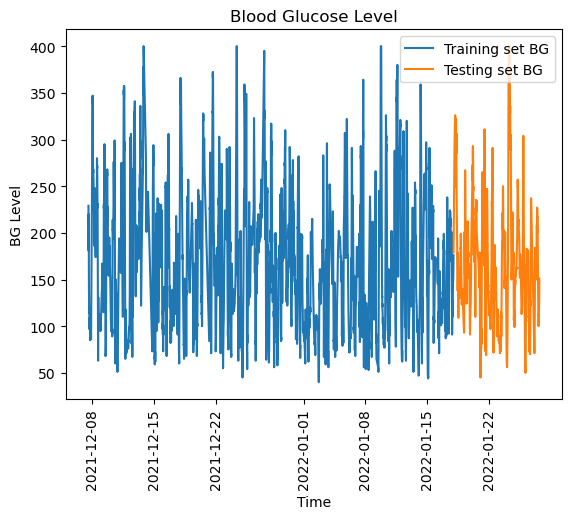

C:\Users\rapha\AppData\Local\Temp\ipykernel_9432\3101832884.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')


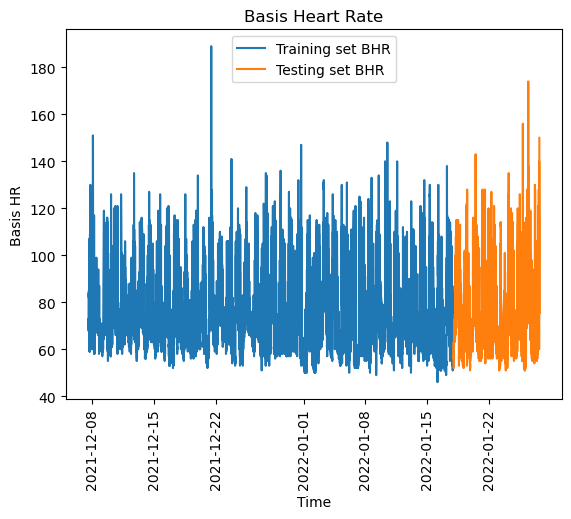

In [108]:
# Blood Glucose
fig, ax = plt.subplots()
ax.plot(merged_train_df.index, merged_train_df['value_BG'], label='Training set BG')
ax.plot(merged_test_df.index, merged_test_df['value_BG'], label='Testing set BG')
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.title("Blood Glucose Level")
plt.xlabel("Time")
plt.ylabel("BG Level")
ax.legend()
plt.show()

# Heart Rate
fig, ax = plt.subplots()
ax.plot(merged_train_df.index, merged_train_df['value_BHR'], label='Training set BHR')
ax.plot(merged_test_df.index, merged_test_df['value_BHR'], label='Testing set BHR')
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.title("Basis Heart Rate")
plt.xlabel("Time")
plt.ylabel("Basis HR")
ax.legend()
plt.show()

In [109]:
print(merged_train_df.shape)
print(merged_test_df.shape)

(19985, 2)
(4284, 2)


### LSTM

In [110]:
# just a function to plot the predictions of a particular model (we will use it later)
def plot_predictions1(model, X, y, start=0, end=500):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

In [111]:
# preparing independant and dependant features
# [[[bg1, bhr1], [bg2, bhr2], [bg3, bhr3], [bg4, bhr4], [bg5, bhr5]]] [bg6]
# [[[bg2, bhr2], [bg3, bhr3], [bg4, bhr4], [bg5, bhr5], [bg6, bhr6]]] [bg7]
# [[[bg3, bhr3], [bg4, bhr4], [bg5, bhr5], [bg6, bhr6], [bg7, bhr7]]] [bg8]

def prepare_data2(timeseries_data, window_size):
    df_as_np = timeseries_data.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np)-window_size):
        row  = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [112]:
window_size2 = 6
X2, y2 = prepare_data2(merged_train_df, window_size2)
X2.shape, y2.shape

((19979, 6, 2), (19979,))

In [113]:
X2_test, y2_test = prepare_data2(merged_test_df, window_size2)
X2_test.shape, y2_test.shape

((4278, 6, 2), (4278,))

In [114]:
X2_train, y2_train = X2[:15000], y2[:15000]
X2_val, y2_val = X2[15000:], y2[15000:]

X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((15000, 6, 2), (15000,), (4979, 6, 2), (4979,), (4278, 6, 2), (4278,))

We do now have to normalize our data to have all our variables on the same scale

In [116]:
bg_training_mean = np.mean(X2_train[:, :, 0])
bg_training_sd = np.mean(X2_train[:, :, 0])

bhr_training_mean = np.mean(X2_train[:, :, 0])
bhr_training_sd = np.mean(X2_train[:, :, 0])

def preprocess(X, mean, sd):
    X[:, :, 0] = (X[:, :, 0] - mean) / sd
    return X


In [117]:
# define model
model2 = Sequential()
model2.add(InputLayer((window_size2, 2)))
model2.add(LSTM(64))
model2.add(Dense(8, 'ReLU'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                17152     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [74]:
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [75]:
model2.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10)

Epoch 1/10
469/469 [==============================] - 6s 7ms/step - loss: 16676.0254 - root_mean_squared_error: 129.1357 - val_loss: 3453.5388 - val_root_mean_squared_error: 58.7668
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 1381.1040 - root_mean_squared_error: 37.1632 - val_loss: 438.9341 - val_root_mean_squared_error: 20.9508
Epoch 3/10
469/469 [==============================] - 4s 7ms/step - loss: 235.0262 - root_mean_squared_error: 15.3306 - val_loss: 135.8458 - val_root_mean_squared_error: 11.6553
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 79.4309 - root_mean_squared_error: 8.9124 - val_loss: 62.1464 - val_root_mean_squared_error: 7.8833
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 37.1624 - root_mean_squared_error: 6.0961 - val_loss: 37.3999 - val_root_mean_squared_error: 6.1155
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 23.7042 - root_mean_squared_error: 4.86

134/134 [==============================] - 1s 2ms/step


(      Predictions  Actuals
 0            0.48   190.20
 1          192.81   191.00
 2          193.49   194.20
 3          196.87   195.00
 4          197.44   198.20
 ...           ...      ...
 4273       146.03   144.80
 4274       146.24   146.00
 4275       146.80   148.00
 4276       148.86   151.00
 4277       153.33   151.00
 
 [4278 rows x 2 columns],
 20.018048653252524)

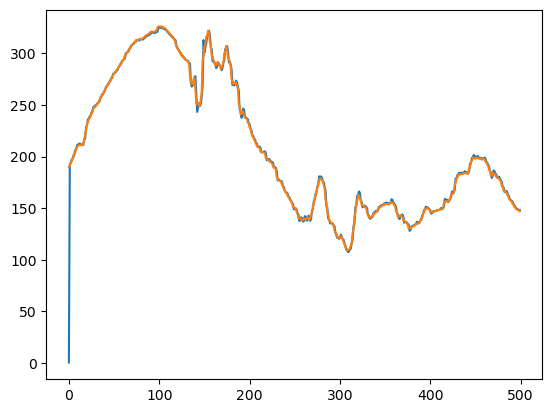

In [76]:
plot_predictions1(model2, X2_test, y2_test)

# LSTM Model For Multivariate Blood Glucose Forecasting

### Pre-processing

The construction of the dataset is detailed in the file dataset.ipynb. We will use here directly the function allowing to create it

In [3]:
import import_ipynb
from pre_processing import build_multivariate_datasets
from sklearn.preprocessing import MinMaxScaler

In [4]:
bg_train_df = pd.read_csv('data/csv/2018/train/559-ws-training-glucose_level.csv')
bg_test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-glucose_level.csv')

bhr_train_df = pd.read_csv('data/csv/2018/train/559-ws-training-basis_heart_rate.csv')
bhr_test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-basis_heart_rate.csv')

bol_train_df = pd.read_csv('data/csv/2018/train/559-ws-training-bolus.csv')
bol_test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-bolus.csv')

bas_train_df = pd.read_csv('data/csv/2018/train/559-ws-training-basal.csv')
bas_test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-basal.csv')

exo_train_df = pd.read_csv('data/csv/2018/train/559-ws-training-exercise.csv')
exo_test_df = pd.read_csv('data/csv/2018/test/559-ws-testing-exercise.csv')

In [5]:
train_df, test_df = build_multivariate_datasets(bg_train_df, bg_test_df,
                                    bhr_train_df, bhr_test_df,
                                    bas_train_df, bas_test_df,
                                    bol_train_df, bol_test_df,
                                    exo_train_df, exo_test_df)

In [19]:
train_df

,value_bg,value_bhr,value_bas,intensity_exo,duration_exo,dose_bolus,bolus_carbs_input
ts,,,,,,,
2021-12-07 12:57:00,240.00,103.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:02:00,229.00,68.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:07:00,223.00,68.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:12:00,214.00,70.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:17:00,210.00,71.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
2022-01-17 23:46:00,168.00,57.80,0.00,0.00,0.00,0.00,0.00
2022-01-17 23:50:00,171.20,57.00,0.00,0.00,0.00,0.00,0.00
2022-01-17 23:51:00,172.00,57.20,0.00,0.00,0.00,0.00,0.00


### LSTM

In [80]:
# preparing independant and dependant features

def prepare_data3(timeseries_data, window_size):
    df_as_np = timeseries_data.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np)-window_size):
        row  = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [81]:
window_size3 = 6

In [82]:
X3, y3 = prepare_data3(train_df, window_size3)
X3.shape, y3.shape

((20214, 6, 7), (20214,))

In [83]:
X3_test, y3_test = prepare_data3(test_df, window_size3)
X3_test.shape, y3_test.shape

((4342, 6, 7), (4342,))

In [84]:
X3_train, y3_train = X3[:17000], y3[:17000]
X3_val, y3_val = X3[17000:], y3[17000:]

X3_train.shape, y3_train.shape, X3_val.shape, y3_val.shape, X3_test.shape, y3_test.shape

((17000, 6, 7), (17000,), (3214, 6, 7), (3214,), (4342, 6, 7), (4342,))

In [85]:
train_df

,value_bg,value_bhr,value_bas,intensity_exo,duration_exo,dose_bolus,bolus_carbs_input
ts,,,,,,,
2021-12-07 12:57:00,240.00,103.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:02:00,229.00,68.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:07:00,223.00,68.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:12:00,214.00,70.00,0.00,0.00,0.00,0.00,0.00
2021-12-07 13:17:00,210.00,71.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
2022-01-17 23:46:00,168.00,57.80,0.00,0.00,0.00,0.00,0.00
2022-01-17 23:50:00,171.20,57.00,0.00,0.00,0.00,0.00,0.00
2022-01-17 23:51:00,172.00,57.20,0.00,0.00,0.00,0.00,0.00


In [95]:
# data normalization
scaler = MinMaxScaler()
train_df_norm = scaler.fit_transform(train_df)
test_df_norm = scaler.fit_transform(test_df)

train_df = pd.DataFrame(train_df_norm, columns=train_df.columns)
test_df = pd.DataFrame(test_df_norm, columns=test_df.columns)

In [96]:
# define model
nb_variable = 7  # nb de variable prises en compte dans le modèle
model3 = Sequential()
model3.add(InputLayer((window_size3, nb_variable)))  
model3.add(LSTM(64))
model3.add(Dense(8, 'ReLU'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                18432     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [97]:
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [98]:
model3.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10)

Epoch 1/10
532/532 [==============================] - 7s 7ms/step - loss: 15933.4473 - root_mean_squared_error: 126.2278 - val_loss: 3431.6177 - val_root_mean_squared_error: 58.5800
Epoch 2/10
532/532 [==============================] - 4s 8ms/step - loss: 1431.3862 - root_mean_squared_error: 37.8337 - val_loss: 435.0051 - val_root_mean_squared_error: 20.8568
Epoch 3/10
532/532 [==============================] - 4s 7ms/step - loss: 260.5339 - root_mean_squared_error: 16.1411 - val_loss: 104.5469 - val_root_mean_squared_error: 10.2248
Epoch 4/10
532/532 [==============================] - 4s 7ms/step - loss: 86.5250 - root_mean_squared_error: 9.3019 - val_loss: 40.4822 - val_root_mean_squared_error: 6.3626
Epoch 5/10
532/532 [==============================] - 4s 7ms/step - loss: 41.4565 - root_mean_squared_error: 6.4387 - val_loss: 23.2498 - val_root_mean_squared_error: 4.8218
Epoch 6/10
532/532 [==============================] - 4s 7ms/step - loss: 26.0020 - root_mean_squared_error: 5.09

136/136 [==============================] - 1s 2ms/step


(      Predictions  Actuals
 0          188.20   190.20
 1          191.79   191.00
 2          192.57   194.20
 3          196.22   195.00
 4          196.87   198.20
 ...           ...      ...
 4337       145.08   144.80
 4338       146.15   146.00
 4339       148.16   148.00
 4340       147.75   151.00
 4341       151.71   151.00
 
 [4342 rows x 2 columns],
 12.101603383222884)

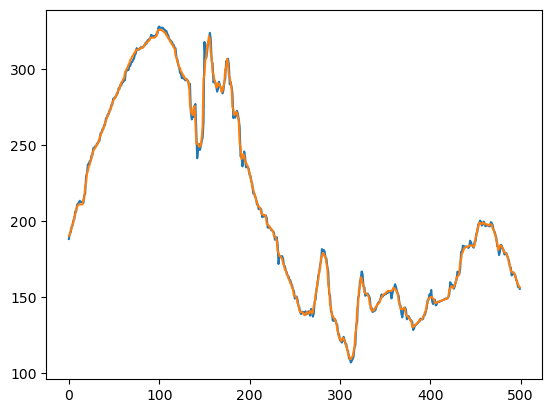

In [99]:
def plot_predictions1(model, X, y, start=0, end=500):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

plot_predictions1(model3, X3_test, y3_test)